##### A sample circuit netlist file processing and visualization.

##### Dataset link: `https://github.com/jpsety/verilog_benchmark_circuits`

Graph has 13 nodes and 14 edges.
Primary Inputs: {'N3', 'N7', 'N6', 'N2', 'N1'}
Primary Outputs: {'N23', 'N22'}


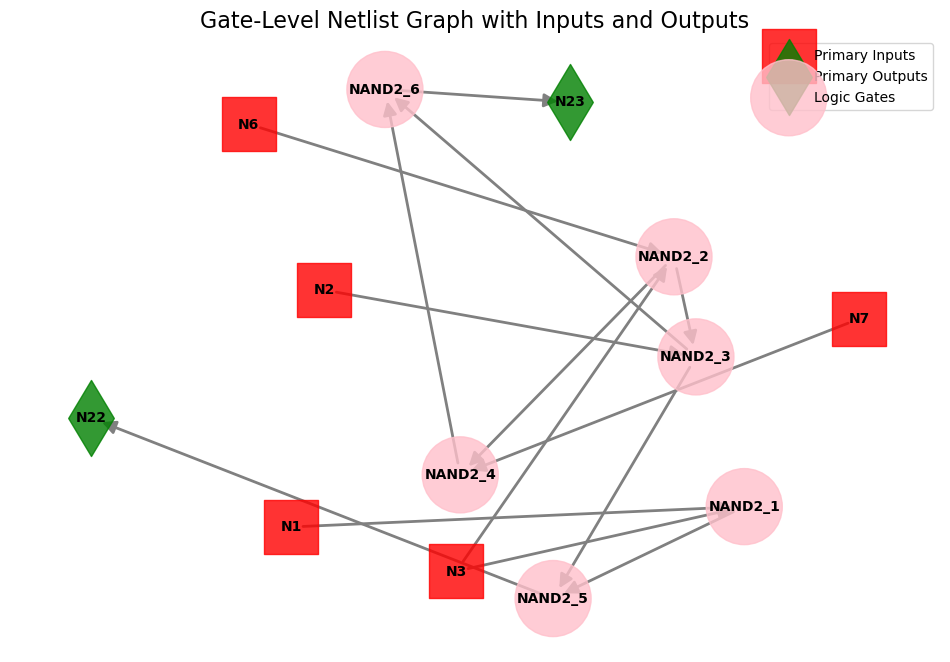

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import re

def parse_verilog_netlist(verilog_file):
    """
    Parses a Verilog gate-level netlist file and converts it into a NetworkX directed graph.
    Identifies primary inputs and primary outputs and connects them properly.
    """
    G = nx.DiGraph()
    
    gate_types = ['and', 'or', 'nand', 'nor', 'xor', 'xnor', 'buf', 'not']
    gates = {}
    all_signals = set()
    output_signals = set()
    input_signals = set()

    with open(verilog_file, 'r') as f:
        lines = f.readlines()

    # Regex pattern to extract gate instances
    gate_pattern = re.compile(rf'\s*({"|".join(gate_types)})\s+(\w+)\s*\((.*)\);')
    
    for line in lines:
        line = line.strip()
        match = gate_pattern.match(line)
        if match:
            gate_type, gate_name, connection_str = match.groups()
            
            signals = [sig.strip() for sig in connection_str.split(',')]
            output_signal = signals[0]  # First signal is the output
            input_signals.update(signals[1:])  # Remaining are inputs

            # Track all signals and outputs
            all_signals.update(signals)
            output_signals.add(output_signal)

            gates[output_signal] = (gate_name, gate_type, signals[1:])
            G.add_node(gate_name, type=gate_type)  # Add gate node

    # Find primary inputs (signals used as inputs but never assigned as an output)
    primary_inputs = input_signals - output_signals

    # Find primary outputs (signals assigned as an output but never used as an input)
    primary_outputs = output_signals - input_signals

    # Add edges based on input-output connections
    for output_signal, (gate_name, gate_type, input_signals) in gates.items():
        for inp in input_signals:
            if inp in gates:
                input_gate_name = gates[inp][0]
                G.add_edge(input_gate_name, gate_name)  # Connect input gate to current gate
            elif inp in primary_inputs:
                G.add_edge(inp, gate_name)  # Connect primary input to current gate

    # Ensure primary inputs are explicitly added to the graph
    for pi in primary_inputs:
        G.add_node(pi, type="input")

    # Ensure primary outputs are explicitly added to the graph and connected properly
    for po in primary_outputs:
        G.add_node(po, type="output")
        if po in gates:
            G.add_edge(gates[po][0], po)  # Connect the producing gate to the primary output

    return G, primary_inputs, primary_outputs

def visualize_circuit_graph(G, primary_inputs, primary_outputs):
    """
    Visualizes the gate-level netlist graph with primary inputs and outputs.
    """
    plt.figure(figsize=(12, 8))

    # Compute positions after ensuring all nodes exist
    pos = nx.spring_layout(G, k=1.5, iterations=50)

    # Identify different node types
    gate_nodes = [n for n in G.nodes if n not in primary_inputs and n not in primary_outputs]

    # Draw primary inputs as squares
    if primary_inputs:
        nx.draw_networkx_nodes(G, pos, nodelist=primary_inputs, node_color='red', node_size=1500, node_shape='s', alpha=0.8, label="Primary Inputs")

    # Draw primary outputs as diamonds
    if primary_outputs:
        nx.draw_networkx_nodes(G, pos, nodelist=primary_outputs, node_color='green', node_size=1500, node_shape='d', alpha=0.8, label="Primary Outputs")

    # Draw gate nodes as circles
    node_colors = {'and': 'lightblue', 'or': 'lightgreen', 'nand': 'pink', 'nor': 'purple',
                   'xor': 'yellow', 'xnor': 'orange', 'buf': 'cyan', 'not': 'gray'}
    colors = [node_colors.get(G.nodes[n]['type'], 'gray') for n in gate_nodes]
    
    if gate_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=gate_nodes, node_color=colors, node_size=3000, alpha=0.8, label="Logic Gates")

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20, width=2)

    # Draw labels
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

    plt.legend()
    plt.title("Gate-Level Netlist Graph with Inputs and Outputs", fontsize=16)
    plt.axis('off')
    plt.show()


# Example usage
if __name__ == "__main__":
    verilog_file = "verilog_benchmark_circuits-master/c17.v"  # Update with your file path
    circuit_graph, primary_inputs, primary_outputs = parse_verilog_netlist(verilog_file)
    
    print(f"Graph has {circuit_graph.number_of_nodes()} nodes and {circuit_graph.number_of_edges()} edges.")
    print(f"Primary Inputs: {primary_inputs}")
    print(f"Primary Outputs: {primary_outputs}")
    
    # Visualize the graph
    visualize_circuit_graph(circuit_graph, primary_inputs, primary_outputs)


##### To train a GCNN, the dataset should include:

Graph Structures: The NetworkX graphs representing each circuit.

Extract Features based on:
- Gate-Level Features
- Connectivity Features
- Structural Features
- Graph-Based Features

In [18]:
import networkx as nx
import pandas as pd
import os
import re
from networkx.exception import NetworkXNoPath

def parse_verilog_netlist(verilog_file):
    """
    Parses a gate-level Verilog netlist and constructs a directed graph.
    Returns the graph, gate dictionary, primary inputs, and primary outputs.
    """
    G = nx.DiGraph()
    gate_types = ['and', 'or', 'nand', 'nor', 'xor', 'xnor', 'buf', 'not']
    gates = {}
    all_signals = set()
    output_signals = set()
    input_signals = set()

    with open(verilog_file, 'r') as f:
        lines = f.readlines()

    print(f'Number of lines in this file: {len(lines)}')
    gate_pattern = re.compile(rf'\s*({"|".join(gate_types)})\s+(\w+)\s*\((.*)\);')

    
    for count_line,line in enumerate(lines):
        if count_line %1000 == 0: print(f'Processing line: {count_line}')
        line = line.strip()
        match = gate_pattern.match(line)
        if match:
            gate_type, gate_name, connection_str = match.groups()
            signals = [sig.strip() for sig in connection_str.split(',')]
            output_signal = signals[0]
            input_signals.update(signals[1:])

            all_signals.update(signals)
            output_signals.add(output_signal)

            gates[output_signal] = (gate_name, gate_type, signals[1:])
            G.add_node(gate_name, type=gate_type)

    primary_inputs = input_signals - output_signals
    primary_outputs = output_signals - input_signals

    for output_signal, (gate_name, gate_type, input_signals) in gates.items():
        for inp in input_signals:
            if inp in gates:
                G.add_edge(gates[inp][0], gate_name)
            elif inp in primary_inputs:
                G.add_edge(inp, gate_name)

    for pi in primary_inputs:
        G.add_node(pi, type="input")

    for po in primary_outputs:
        G.add_node(po, type="output")
        if po in gates:
            G.add_edge(gates[po][0], po)

    return G, gates, primary_inputs, primary_outputs

def extract_features(G, gates, primary_inputs, primary_outputs, circuit_name):
    """
    Extracts structural and graph-based features from the netlist.
    Handles disconnected nodes safely.
    """
    features = []
    degrees = dict(G.degree())

    # Compute graph centralities
    centrality_deg = nx.degree_centrality(G)
    centrality_betw = nx.betweenness_centrality(G, k=min(100, len(G)))  # Speed-up for large graphs
    centrality_close = nx.closeness_centrality(G)
    clustering_coeff = nx.clustering(G)
    print(f'Length of nodes: {len(G.nodes)}')
    for node in G.nodes:
        node_type = G.nodes[node]['type']
        is_primary_input = 1 if node in primary_inputs else 0
        is_primary_output = 1 if node in primary_outputs else 0
        is_internal_node = 1 if not (is_primary_input or is_primary_output) else 0

        fan_in = G.in_degree(node)
        fan_out = G.out_degree(node)

        neighbors = list(G.neighbors(node))
        avg_fan_in_neighbors = sum(G.in_degree(n) for n in neighbors) / len(neighbors) if neighbors else 0
        avg_fan_out_neighbors = sum(G.out_degree(n) for n in neighbors) / len(neighbors) if neighbors else 0

        try:
            depth = nx.shortest_path_length(G, source=node) if not is_primary_input else 0
        except (NetworkXNoPath, KeyError):
            depth = -1  # Default if no path exists

        try:
            distance_to_outputs = min(nx.shortest_path_length(G, source=node, target=po) for po in primary_outputs if nx.has_path(G, node, po)) if is_internal_node else 0
        except (NetworkXNoPath, ValueError):
            distance_to_outputs = -1  # Default if no path exists

        is_key_gate = 1 if node_type in ['xor', 'xnor'] else 0  # Logic locking gates
        key_dependency = node if is_key_gate else None

        features.append({
            'circuit_name': circuit_name,
            'node': node,
            'gate_type': node_type,
            'fan_in': fan_in,
            'fan_out': fan_out,
            'depth': depth,
            'dist_to_output': distance_to_outputs,
            'is_primary_input': is_primary_input,
            'is_primary_output': is_primary_output,
            'is_internal': is_internal_node,
            'is_key_gate': is_key_gate,
            'key_dependency': key_dependency,
            'degree_centrality': centrality_deg.get(node, 0),
            'betweenness_centrality': centrality_betw.get(node, 0),
            'closeness_centrality': centrality_close.get(node, 0),
            'clustering_coefficient': clustering_coeff.get(node, 0),
            'avg_fan_in_neighbors': avg_fan_in_neighbors,
            'avg_fan_out_neighbors': avg_fan_out_neighbors,
        })

    return pd.DataFrame(features)

def process_all_netlists(folder_path):
    """
    Processes all .v files in the folder efficiently and combines extracted features into a single DataFrame.
    """
    all_features = []
    
    print(f'Files to b processed: {os.listdir(folder_path)}')
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".v"):
            file_path = os.path.join(folder_path, filename)
            print(f"Processing: *****{filename}******")

            try:
                circuit_graph, gates, primary_inputs, primary_outputs = parse_verilog_netlist(file_path)
                circuit_features = extract_features(circuit_graph, gates, primary_inputs, primary_outputs, filename)
                all_features.append(circuit_features)
            except Exception as e:
                print(f"⚠️ Skipping {filename} due to error: {e}")

    if all_features:
        final_df = pd.concat(all_features, ignore_index=True)
        final_df.to_csv("all_circuits_features.csv", index=False)
        print("\n✅ Feature extraction completed. Saved to all_circuits_features.csv")
    else:
        print("\n❌ No valid netlist files were processed.")

# Example usage
if __name__ == "__main__":
    netlist_folder = "verilog_benchmark_circuits-master"  # Update path
    process_all_netlists(netlist_folder)


Files to b processed: ['.ipynb_checkpoints', 'adder.v', 'arbiter.v', 'bar.v', 'c1355.v', 'c17.v', 'c1908.v', 'c2670.v', 'c3540.v', 'c432.v', 'c499.v', 'c5315.v', 'c6288.v', 'c7552.v', 'c880.v', 'cavlc.v', 'ctrl.v', 'dec.v', 'i2c.v', 'int2float.v', 'max.v', 'Priority.v', 'router.v', 'sin.v']
Processing: *****adder.v******
Number of lines in this file: 2595
Processing line: 0
Processing line: 1000
Processing line: 2000
Length of nodes: 2547
Processing: *****arbiter.v******
Number of lines in this file: 26540
Processing line: 0
Processing line: 1000
Processing line: 2000
Processing line: 3000
Processing line: 4000
Processing line: 5000
Processing line: 6000
Processing line: 7000
Processing line: 8000
Processing line: 9000
Processing line: 10000
Processing line: 11000
Processing line: 12000
Processing line: 13000
Processing line: 14000
Processing line: 15000
Processing line: 16000
Processing line: 17000
Processing line: 18000
Processing line: 19000
Processing line: 20000
Processing line: 2

#### Display and describe the content of `all_circuits_features.csv`.

In [1]:
import pandas as pd

# Load the extracted features CSV file
df = pd.read_csv("all_circuits_features.csv")

# Display the first few rows
print("\n🔹 First 5 rows of the DataFrame:")
print(df.head())

# Summary statistics
print("\n🔹 DataFrame Summary:")
print(df.info())

print("\n🔹 Statistical Summary:")
print(df.describe())

# Check for missing values
print("\n🔹 Missing Values in Each Column:")
print(df.isnull().sum())

# Count the number of circuits processed
num_circuits = df['circuit_name'].nunique()
num_nodes = df.shape[0]
print(f"\n✅ Number of circuits processed: {num_circuits}")
print(f"✅ Total number of nodes (gates + inputs/outputs): {num_nodes}")

# Count of different gate types
print("\n🔹 Gate Type Distribution:")
print(df['gate_type'].value_counts())

# Check the number of key gates detected
num_key_gates = df['is_key_gate'].sum()
print(f"\n🔑 Number of detected key gates: {num_key_gates}")


C:\Users\rrk307\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rrk307\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



🔹 First 5 rows of the DataFrame:
  circuit_name node gate_type  fan_in  fan_out  \
0      adder.v   g1       not       1        1   
1      adder.v   g2       and       2        1   
2      adder.v   g3       not       1        1   
3      adder.v   g4       and       2        1   
4      adder.v   g5        or       2        1   

                                      depth  dist_to_output  is_primary_input  \
0  {'g1': 0, 'g2': 1, 'g5': 2, '\\f[0]': 3}               3                 0   
1           {'g2': 0, 'g5': 1, '\\f[0]': 2}               2                 0   
2  {'g3': 0, 'g4': 1, 'g5': 2, '\\f[0]': 3}               3                 0   
3           {'g4': 0, 'g5': 1, '\\f[0]': 2}               2                 0   
4                    {'g5': 0, '\\f[0]': 1}               1                 0   

   is_primary_output  is_internal  is_key_gate key_dependency  \
0                  0            1            0            NaN   
1                  0            1            0  